<h2>Formula 1 Grand Prix status prediction</h2>

In [3]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder ,RobustScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle
from autogluon.tabular import TabularPredictor

plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [4]:
rounds = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_round.csv')
round_entries = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_roundentry.csv')
sessions = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_session.csv')
session_entries = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_sessionentry.csv')
team_drivers = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_teamdriver.csv')
drivers = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_driver.csv')
teams = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_team.csv')
circuits = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_circuit.csv')
laps = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_lap.csv')

race_weather = pd.read_csv(r'../data/raw/race_weather.csv')
circuit_type = pd.read_csv(r'../data/raw/circuit_type.csv')

In [5]:
df1 = pd.merge(rounds, sessions, how='left', left_on='id', right_on='round_id', suffixes=('_round', '_session'))
df2 = pd.merge(df1,round_entries,how='left',left_on='id_round', right_on='round_id', suffixes=('', '_round_entry'))
df2 = df2.rename(columns={'id': 'id_round_entry'})
df3 = pd.merge(df2,session_entries,how='left',left_on=['id_round_entry', 'id_session'],right_on=['round_entry_id', 'session_id'],suffixes=('', '_session_entry'))
df3 = df3.rename(columns={'id': 'id_session_entry'})
df4 = pd.merge(df3,team_drivers,how='left',left_on='team_driver_id',right_on='id',suffixes=('', '_team_driver'))
df4 = df4.rename(columns={'id': 'id_team_driver'})
df5 = pd.merge(df4,drivers,how='left',left_on='driver_id',right_on='id',suffixes=('', '_driver'))
df5 = df5.rename(columns={'id': 'id_driver'})
df6 = pd.merge(df5,teams,how='left',left_on='team_id',right_on='id',suffixes=('', '_team'))
df6 = df6.rename(columns={'id': 'id_team'})
df7 = pd.merge(df6,circuits,how='left',left_on='circuit_id',right_on='id',suffixes=('', '_circuit'))
df7 = df7.rename(columns={'id': 'id_circuit'})
df8 = pd.merge(df7,laps,how='left',left_on='id_session_entry',right_on='session_entry_id',suffixes=('', '_lap'))
df8 = df8.rename(columns={'id': 'id_lap'})

In [6]:
data = df8

data = data.drop(['abbreviation', 'altitude', 'average_speed', 'base_team_id', 'car_number', 'circuit_id', 'country', 'date_session', 'detail','fastest_lap_rank', 'forename', 'id_circuit', 'id_round', 'id_round_entry', 'id_session', 'id_session_entry', 'id_driver', 'id_team', 'id_team_driver', 'id_lap', 'is_deleted', 'is_eligible_for_points', 'is_entry_fastest_lap', 'laps_completed', 'latitude', 'locality', 'longitude', 'name', 'name_team', 'name_circuit', 'nationality', 'nationality_team', 'number','number_round', 'number_session', 'permanent_car_number', 'point_system_id', 'points' , 'position', 'position_lap', 'race_number', 'role', 'round_entry_id', 'round_id', 'round_id_round_entry', 'scheduled_laps', 'season_id', 'season_id_team_driver', 'session_entry_id', 'session_id', 'status', 'surname', 'team_driver_id', 'team_id', 'time', 'wikipedia', 'wikipedia_circuit', 'wikipedia_driver', 'wikipedia_team', 'time_lap' ,'time_session_entry' ],axis=1)

In [7]:
# renames
data.rename(columns={'date_round':'date',
                     'grid':'qualification_position','country_code':'driver_nationality',
                    'country_code_team':'constructor_nationality'
                    ,'country_code_circuit':'circuit_nationality',
                     'reference_team': 'constructor',
                     'reference': 'driver',
                     'reference_circuit': 'circuit',
                     'date_of_birth':'driver_date_of_birth'},inplace=True)

In [8]:
#Take only  column 'type' of value 'R' as race
data = data[data['type']=='R']
#take only rows where 'is_cancelled_round', 'is_cancelled_session' are 'f'
data = data[(data['is_cancelled_round']=='f')]
data = data[(data['is_cancelled_session']=='f')]

data.drop(['is_cancelled_round', 'is_cancelled_session', 'type'],axis=1,inplace=True)

# drop where is clssified is null or nan
data = data[data['is_classified'].notna()]
data.columns

Index(['date', 'qualification_position', 'is_classified', 'driver_id',
       'driver_nationality', 'driver_date_of_birth', 'driver',
       'constructor_nationality', 'constructor', 'circuit_nationality',
       'circuit'],
      dtype='object')

In [7]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData.columns
#export test data to csv
#testData.to_csv('testData.csv', index=False)


Index(['year', 'date', 'weather', 'driverId', 'grid', 'laps', 'milliseconds',
       'forename', 'surname', 'dob', 'nationality', 'name_constructor',
       'nationality_constructor', 'name_circuit', 'country', 'type', 'status'],
      dtype='object')

In [10]:
# Specify the date format explicitly
data['date'] = pd.to_datetime(data['date'])
data['driver_date_of_birth'] = pd.to_datetime(data['driver_date_of_birth'])

#get month and day from date into new columns
data['race_month'] = data['date'].dt.month
data['race_day'] = data['date'].dt.day
data['race_year'] = data['date'].dt.year


In [11]:
data['age_at_gp_in_days'] = abs(data['driver_date_of_birth']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driver_id')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driver_id', how='left')
data = data.drop(['driver_id'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [12]:
# load race_weather csv, join by race date
race_weather['date'] = pd.to_datetime(race_weather['date'])
data = data.merge(race_weather, how='left', left_on='date', right_on='date', suffixes=('', '_race_weather'))
data = data[data['weather'].notna()]

In [13]:
#create a rain column where if the weather is 'Rain or 'Changeable' or 'Very changeable' then 1 else 0
data['rain'] = data['weather'].apply(lambda x: 1 if x in ['Rain', 'Changeable', 'Very changeable'] else 0)
#drop the weather column
data = data.drop(['weather'],axis=1)

In [14]:
# Merge circuit type
data = data.merge(circuit_type, how='left', left_on='circuit', right_on='circuit', suffixes=('', '_circuit_type'))

In [15]:
#select all data from 1980
data = data[data['race_year']>=1981]
#get first nationality only


In [21]:
print(data.columns)

Index(['date', 'qualification_position', 'is_classified', 'driver_nationality',
       'driver_date_of_birth', 'driver', 'constructor_nationality',
       'constructor', 'circuit_nationality', 'circuit', 'race_month',
       'race_day', 'race_year', 'age_at_gp_in_days', 'first_race_date',
       'days_since_first_race', 'rain', 'type_circuit'],
      dtype='object')


In [22]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['williams' 'brabham' 'alfa' 'tyrrell' 'theodore' 'fittipaldi' 'renault'
 'ensign' 'ferrari' 'ligier' 'ats' 'arrows' 'osella' 'team_lotus'
 'mclaren' 'march' 'toleman' 'ram' 'spirit' 'minardi' 'zakspeed' 'lola'
 'benetton' 'ags' 'larrousse' 'coloni' 'rial' 'eurobrun' 'dallara' 'onyx'
 'leyton' 'lambo' 'jordan' 'footwork' 'fondmetal' 'moda' 'sauber' 'simtek'
 'pacific' 'forti' 'prost' 'stewart' 'bar' 'jaguar' 'toyota' 'red_bull'
 'honda' 'toro_rosso' 'bmw_sauber' 'mf1' 'super_aguri' 'spyker_mf1'
 'spyker' 'force_india' 'brawn' 'mercedes' 'lotus_racing' 'hrt' 'virgin'
 'lotus_f1' 'marussia' 'caterham' 'manor' 'haas' 'racing_point'
 'alphatauri' 'aston_martin' 'alpine' 'rb']


In [23]:
data['constructor_nationality'].unique()


array(['GBR', 'CHE', 'HKG', 'BRA', 'FRA', 'ITA', 'DEU', 'IRL', 'JPN',
       'AUT', 'RUS', 'NLD', 'IND', 'MYS', 'ESP', 'USA'], dtype=object)

In [16]:
#data after processing nationalities
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [17]:
# dnf is 1 if is_classified is = 'f' else 0
data['dnf'] = data['is_classified'].apply(lambda x: 0 if x == 't' else 1)
data = data.drop(['is_classified'],axis=1)
data.drop_duplicates(inplace=True)
data


,date,qualification_position,driver_nationality,driver_date_of_birth,driver,constructor_nationality,constructor,circuit_nationality,circuit,race_month,race_day,race_year,age_at_gp_in_days,first_race_date,days_since_first_race,rain,type_circuit,driver_home,constructor_home,dnf
336,1981-03-15,2.00,AUS,1946-11-02,jones,GBR,williams,USA,long_beach,3,15,1981,12552,1975-04-27,2149,0,Street circuit,0,0,0
337,1981-03-15,3.00,ARG,1942-04-12,reutemann,GBR,williams,USA,long_beach,3,15,1981,14217,1972-01-23,3339,0,Street circuit,0,0,0
338,1981-03-15,4.00,BRA,1952-08-17,piquet,GBR,brabham,USA,long_beach,3,15,1981,10437,1978-07-30,959,0,Street circuit,0,0,0
339,1981-03-15,6.00,USA,1940-02-28,mario_andretti,CHE,alfa,USA,long_beach,3,15,1981,14991,1968-10-06,4543,0,Street circuit,1,0,0
340,1981-03-15,8.00,USA,1958-01-10,cheever,GBR,tyrrell,USA,long_beach,3,15,1981,8465,1978-03-04,1107,0,Street circuit,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614477,2025-09-21,3.00,NZL,2002-02-11,lawson,ITA,rb,AZE,baku,9,21,2025,8623,2023-08-27,756,0,Street circuit,0,0,0
614528,2025-09-21,19.00,THA,1996-03-23,albon,GBR,williams,AZE,baku,9,21,2025,10774,2019-03-17,2380,0,Street circuit,0,0,0
614579,2025-09-21,2.00,ESP,1994-09-01,sainz,GBR,williams,AZE,baku,9,21,2025,11343,2015-03-15,3843,0,Street circuit,0,0,0
614630,2025-09-21,17.00,DEU,1987-08-19,hulkenberg,CHE,sauber,AZE,baku,9,21,2025,13913,2010-03-14,5670,0,Street circuit,0,0,0


<h3>Testing different models on cleaned data (For main race)</h3>

In [65]:
# Drop irrelevant columns
columns_to_drop = [ 'driver_date_of_birth', 'date', 'first_race_date']


cleaned_data = data.drop(columns=columns_to_drop)
cleaned_data.drop_duplicates(inplace=True)

In [71]:

robust_cols = ['qualification_position', 'age_at_gp_in_days', 'days_since_first_race', 'race_year']
cat_cols = ['constructor','circuit','type_circuit','driver','circuit_nationality','driver_nationality','constructor_nationality','race_month','race_day' ,'rain', 'driver_home', 'constructor_home']
other_cols = []

target = 'dnf'
# force categorical columns to string type
for col in cat_cols:
    cleaned_data[col] = cleaned_data[col].astype('category')
cleaned_data[target] = cleaned_data[target].astype('category')
cleaned_data.dtypes

qualification_position      float64
driver_nationality         category
driver                     category
constructor_nationality    category
constructor                category
circuit_nationality        category
circuit                    category
race_month                 category
race_day                   category
race_year                     int32
age_at_gp_in_days             int64
days_since_first_race         int64
rain                       category
type_circuit               category
driver_home                category
constructor_home           category
dnf                        category
dtype: object

In [72]:
# Split features and target
y = cleaned_data['dnf']
X = cleaned_data.drop(columns=['dnf'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [73]:
#evalation functions

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    return y_pred, y_proba



<h2>Autogluon</h2

In [86]:
# Combine X_train and y_train for AutoGluon
train_data = X_train.copy()
train_data['dnf'] = y_train

# Initialize and fit predictor
predictor = TabularPredictor(label='dnf', path='../models/autogluon_models/status_predictor', problem_type='binary', eval_metric='roc_auc').fit(train_data, presets='medium_quality').save()


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       31.73 GB / 63.11 GB (50.3%)
Disk Space Avail:   645.74 GB / 976.56 GB (66.1%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ...
AutoGluon will save models to "D:\f1-fantasy-ml-api\models\autogluon_models\status_predictor"
Train Data Rows:    14340
Train Data Columns: 16
Label Column:       dnf
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    32475.79 MB
	Train Data (Original)  Memory Usage: 0.59 MB (0.0% of available memory)
	Inferring data type of each featur

In [88]:
predictor = TabularPredictor.load('../models/autogluon_models/status_predictor')

# Predict on test set
y_pred = predictor.predict(X_test)
y_proba = predictor.predict_proba(X_test)[1]  # Probability for class 1

# Evaluate
perf = predictor.evaluate(X_test.assign(dnf=y_test))
print(perf)

{'roc_auc': np.float64(0.7349923107840007), 'accuracy': 0.7158393753485778, 'balanced_accuracy': np.float64(0.6318062745142753), 'mcc': 0.29864884201897063, 'f1': 0.47284014485256076, 'precision': 0.5866495507060334, 'recall': 0.39601386481802425}


In [89]:
performance = predictor.evaluate(X_test.assign(dnf=y_test))
performance

{'roc_auc': np.float64(0.7349923107840007),
 'accuracy': 0.7158393753485778,
 'balanced_accuracy': np.float64(0.6318062745142753),
 'mcc': 0.29864884201897063,
 'f1': 0.47284014485256076,
 'precision': 0.5866495507060334,
 'recall': 0.39601386481802425}

In [90]:
predictor.leaderboard(X_test.assign(dnf=y_test))

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.74,0.73,roc_auc,0.01,0.01,0.71,0.01,0.01,0.71,1,True,9
1,CatBoost,0.74,0.73,roc_auc,0.02,0.00,15.09,0.02,0.00,15.09,1,True,5
2,WeightedEnsemble_L2,0.73,0.74,roc_auc,0.21,0.08,29.58,0.00,0.00,0.05,2,True,12
3,LightGBMXT,0.73,0.73,roc_auc,0.01,0.01,0.48,0.01,0.01,0.48,1,True,1
4,LightGBMLarge,0.73,0.72,roc_auc,0.01,0.01,0.77,0.01,0.01,0.77,1,True,11
5,LightGBM,0.73,0.72,roc_auc,0.00,0.00,0.45,0.00,0.00,0.45,1,True,2
6,RandomForestEntr,0.72,0.70,roc_auc,0.10,0.04,0.76,0.10,0.04,0.76,1,True,4
7,NeuralNetTorch,0.72,0.72,roc_auc,0.02,0.01,5.89,0.02,0.01,5.89,1,True,10
8,ExtraTreesEntr,0.72,0.71,roc_auc,0.15,0.04,0.46,0.15,0.04,0.46,1,True,7
9,RandomForestGini,0.72,0.71,roc_auc,0.10,0.04,0.68,0.10,0.04,0.68,1,True,3


In [78]:
predictor.feature_importance(X_test.assign(dnf=y_test))


Computing feature importance via permutation shuffling for 16 features using 3586 rows with 5 shuffle sets...
	35.66s	= Expected runtime (7.13s per shuffle set)
	10.32s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
race_year,0.11,0.01,0.00,5,0.13,0.10
qualification_position,0.01,0.00,0.00,5,0.02,0.01
constructor,0.01,0.00,0.00,5,0.01,0.00
days_since_first_race,0.00,0.00,0.00,5,0.01,0.00
driver,0.00,0.00,0.03,5,0.01,-0.00
circuit,0.00,0.00,0.01,5,0.00,-0.00
type_circuit,0.00,0.00,0.02,5,0.00,-0.00
constructor_nationality,0.00,0.00,0.00,5,0.00,0.00
rain,0.00,0.00,0.09,5,0.00,-0.00
race_day,0.00,0.00,0.03,5,0.00,-0.00


<h3> Random forest classifier</h3>

In [39]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid

param_grid = {
    'model__max_depth': [30],
    'model__min_samples_leaf': [ 4],
    'model__min_samples_split': [10],
    'model__n_estimators': [ 800]
}
# param_grid = {
#     'model__max_depth': [30],
#     'model__min_samples_leaf': [2, 3, 4],
#     'model__min_samples_split': [10, 15],
#     'model__n_estimators': [600, 800]
# }
# 
# Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 800}

# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc', 
    verbose=1,
    n_jobs=-1
)

# Train models
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final models
best_model_rf = grid_search.best_estimator_

# Predict on test set
evaluate_model(best_model_rf, X_test, y_test)




Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 800}
Best ROC AUC Score (CV): 0.7287

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2432
           1       0.62      0.28      0.39      1154

    accuracy                           0.71      3586
   macro avg       0.68      0.60      0.60      3586
weighted avg       0.69      0.71      0.68      3586

Confusion Matrix:
[[2236  196]
 [ 832  322]]
ROC AUC Score: 0.7374


(array([0, 0, 0, ..., 0, 0, 1], shape=(3586,)),
 array([0.47923308, 0.18376527, 0.4877121 , ..., 0.35713343, 0.10408612,
        0.50725937], shape=(3586,)))

C:\Users\Linh\AppData\Local\Temp\ipykernel_2364\1648476756.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


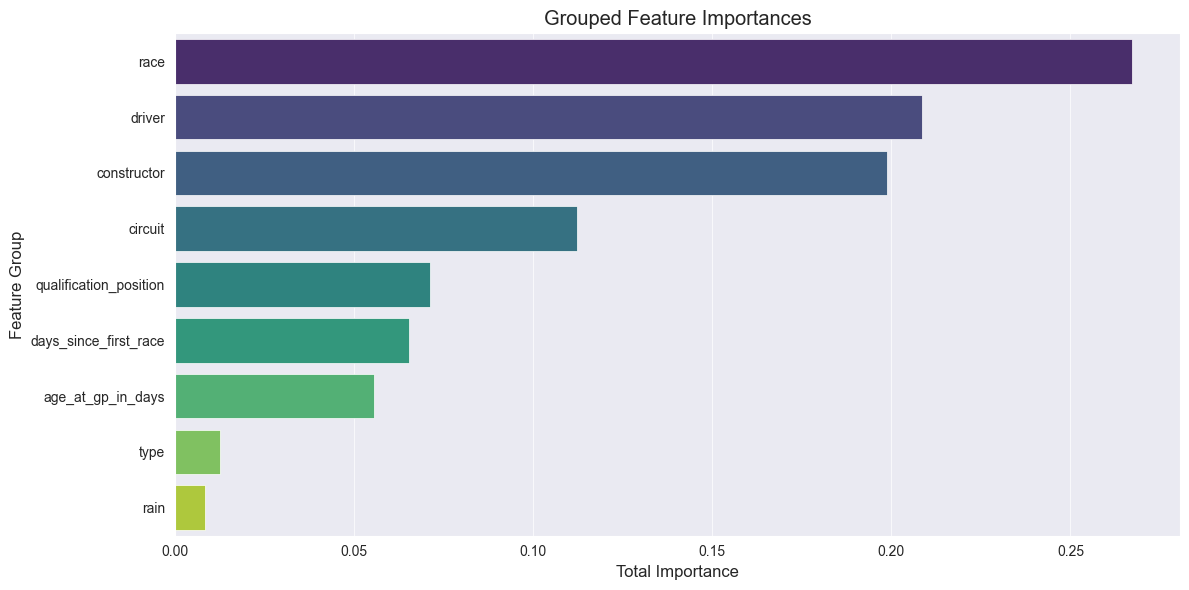

In [40]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [37]:
# save
with open('rf_status.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


In [33]:

failure_probs = best_model_rf.predict_proba(X_test)[:, 1]
failure_probs

array([0.48675194, 0.13149242, 0.5357404 , ..., 0.38787817, 0.09723087,
       0.51921021], shape=(3586,))

<h5>Gradient boost Classifier</h5>

In [41]:
# Split features and target
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier(verbose=1))
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__loss': [ 'log_loss'],
    'model__learning_rate': [0.01],
    'model__n_estimators': [ 400],
    'model__min_samples_split': [  15],
    'model__min_samples_leaf': [ 5],
    'model__max_depth': [ 5],
}
# param_grid = {
#     'model__loss': [ 'log_loss', 'exponential'],
#     'model__learning_rate': [0.01, 0.1],
#     'model__n_estimators': [ 300, 400],
#     'model__min_samples_split': [ 10, 15],
#     'model__min_samples_leaf': [ 4, 5],
#     'model__max_depth': [ 4, 5],
# }

# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc', 
    verbose=1,
    n_jobs=-1
)

# Train models
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final models
best_model_gb = grid_search.best_estimator_

# Predict on test set
evaluate_model(best_model_gb, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
      Iter       Train Loss   Remaining Time 
         1           1.2696           49.58s
         2           1.2679           48.12s
         3           1.2662           46.98s
         4           1.2646           46.59s
         5           1.2630           46.18s
         6           1.2615           45.99s
         7           1.2599           46.24s
         8           1.2584           46.20s
         9           1.2569           45.89s
        10           1.2555           45.85s
        20           1.2423           45.00s
        30           1.2306           43.87s
        40           1.2207           43.11s
        50           1.2113           42.97s
        60           1.2031           41.62s
        70           1.1957           40.14s
        80           1.1879           38.81s
        90           1.1808           37.50s
       100           1.1749           36.37s
       200           1.1329           25

(array([0, 0, 0, ..., 0, 0, 1], shape=(3586,)),
 array([0.48589776, 0.17802016, 0.43139921, ..., 0.39723251, 0.12311237,
        0.55742996], shape=(3586,)))

C:\Users\Linh\AppData\Local\Temp\ipykernel_2364\285344360.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


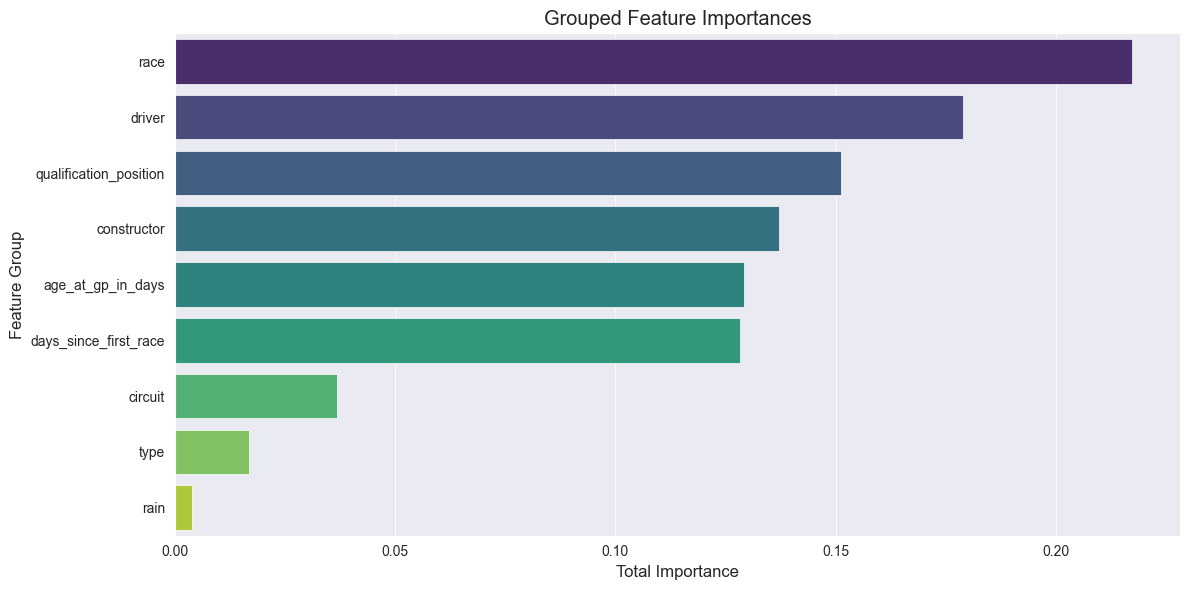

In [42]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [42]:
# save
with open('gb_status.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h3>Logistic Regression</h3>

In [46]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')


# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(verbose=1))
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__C': [0.1,],
    'model__penalty': ['l2'],
    'model__solver': ['liblinear'],
    'model__max_iter': [100]
}
# param_grid = {
#     'model__C': [0.1, 1.0, 10.0],
#     'model__penalty': ['l2','l1'],
#     'model__solver': ['lbfgs','liblinear'],
#     'model__max_iter': [100,200,300]
# }

#[LibLinear]Best Parameters: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Train models
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final models
best_model_lg = grid_search.best_estimator_

# Predict on test set
evaluate_model(best_model_lg, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear]Best Parameters: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best ROC AUC Score (CV): 0.7275

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      2432
           1       0.58      0.38      0.46      1154

    accuracy                           0.71      3586
   macro avg       0.66      0.62      0.63      3586
weighted avg       0.69      0.71      0.69      3586

Confusion Matrix:
[[2117  315]
 [ 717  437]]
ROC AUC Score: 0.7313


(array([1, 0, 1, ..., 0, 0, 1], shape=(3586,)),
 array([0.50637552, 0.12916352, 0.55656868, ..., 0.40161288, 0.12696494,
        0.60004187], shape=(3586,)))

In [44]:
# save
with open('lg_status.pkl','wb') as f:
    pickle.dump(best_model_lg,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

In [45]:
#one hot encoding example for a single column of driver with 3 values
df = pd.DataFrame({'driver': ['Lewis', 'Max', 'Oscar']})
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['driver']])
encoded = ohe.transform(df[['driver']])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['driver']))
#print 2 dataframes to visual graph
print("Original DataFrame:")
print(df)
print("\nOne-Hot Encoded DataFrame:")

Original DataFrame:
  driver
0  Lewis
1    Max
2  Oscar

One-Hot Encoded DataFrame:
